In [3]:
from time import perf_counter
import numpy as np,os
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler, power_transform, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.utils import shuffle
from sklearn.metrics import matthews_corrcoef, precision_recall_curve, auc, accuracy_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, EditedNearestNeighbours, TomekLinks
from imblearn.pipeline import make_pipeline, Pipeline
import seaborn as sns,matplotlib.pyplot as plt
import warnings; warnings.filterwarnings('ignore')

from library.configs import CLFS, IMBS, CV, SCORERS
from library.utils import evaluate, read_data

In [4]:
DATASETS = ['groovy-1_5_7.csv','jruby-1.4.0.csv','lucene-2.9.0.csv','jruby-1.7.0.preview1.csv','groovy-1_6_BETA_1.csv',
        'derby-10.2.1.6.csv','wicket-1.5.3.csv','camel-2.9.0.csv','camel-1.4.0.csv','activemq-5.8.0.csv']
#DATASETS = [f for f in os.listdir("JIRA/") if 'csv' in f]
len(DATASETS)

10

In [5]:
NOISE_TYPES = ['No','FN-Only','FP-Only','Both']
CV = RepeatedStratifiedKFold(n_splits=5,n_repeats=2,random_state=99)

In [6]:
models = {}
for im,samp in IMBS.items():
    for c,clf in CLFS.items():
        models[(im,c)] = Pipeline([('samp',samp),('clf',clf)])
models.keys(),len(models)

(dict_keys([('smote', 'dt'), ('smote', 'lr'), ('smote', 'nb'), ('smote', 'svm'), ('smote', 'knn'), ('smote', 'rf'), ('rus', 'dt'), ('rus', 'lr'), ('rus', 'nb'), ('rus', 'svm'), ('rus', 'knn'), ('rus', 'rf'), ('wilson', 'dt'), ('wilson', 'lr'), ('wilson', 'nb'), ('wilson', 'svm'), ('wilson', 'knn'), ('wilson', 'rf'), ('tomek', 'dt'), ('tomek', 'lr'), ('tomek', 'nb'), ('tomek', 'svm'), ('tomek', 'knn'), ('tomek', 'rf'), ('None', 'dt'), ('None', 'lr'), ('None', 'nb'), ('None', 'svm'), ('None', 'knn'), ('None', 'rf')]),
 30)

In [7]:
from sklearn.metrics import confusion_matrix
FRACS = [0,.25,.5,.75,1.0]
cols = pd.MultiIndex.from_product([FRACS,IMBS.keys(),CLFS.keys(),[f.__name__ for f in SCORERS]],names=['frac','imb','clf','metric'])
df = pd.DataFrame(index=DATASETS,columns=cols)
for it,d in enumerate(DATASETS):
    print(it)
    X,y_noisy,y_real = read_data(d,stats=True)
    C = np.argwhere(y_real==1).ravel()
    N = np.argwhere(y_noisy==0).ravel()  #PN
    idx = np.intersect1d(N,C)
    tn, fp, fn, tp = confusion_matrix(y_real,y_noisy).ravel()
    print("idx:",len(idx),fn,len(N),len(C))
    for frac in FRACS:
        print("frac:",frac)
        y = y_real.copy()
        size = int(frac*len(idx))
        to_pollute = np.random.choice(idx.copy(),size=size,replace=False)
        y[to_pollute] = 0
        print(len(idx),len(to_pollute))
        print(f"{precision_score(y_real,y):.3f},{recall_score(y_real,y):.3f}",(y_real!=y).sum())
        
        for k in models:
            r = evaluate(models[k],X,y,y_real,CV,SCORERS)
            for f in r:
                df.loc[d,(frac,k[0],k[1],f)] = r[f].mean()
    df.to_csv("PN10.csv")
    print()

0
groovy-1_5_7.csv noise:0.085, imb:8.463,80,677, Shape:(757, 65)
idx: 5 5 677 26
frac: 0
5 0
1.000,1.000 0
frac: 0.25
5 1
1.000,0.962 1
frac: 0.5
5 2
1.000,0.923 2
frac: 0.75
5 3
1.000,0.885 3
frac: 1.0
5 5
1.000,0.808 5

1
jruby-1.4.0.csv noise:0.190, imb:3.890,200,778, Shape:(978, 65)
idx: 83 83 778 180
frac: 0
83 0
1.000,1.000 0
frac: 0.25
83 20
1.000,0.889 20
frac: 0.5
83 41
1.000,0.772 41
frac: 0.75
83 62
1.000,0.656 62
frac: 1.0
83 83
1.000,0.539 83

2
lucene-2.9.0.csv noise:0.226, imb:3.921,278,1090, Shape:(1368, 65)
idx: 152 152 1090 273
frac: 0
152 0
1.000,1.000 0
frac: 0.25
152 38
1.000,0.861 38
frac: 0.5
152 76
1.000,0.722 76
frac: 0.75
152 114
1.000,0.582 114
frac: 1.0
152 152
1.000,0.443 152

3
jruby-1.7.0.preview1.csv noise:0.099, imb:8.902,163,1451, Shape:(1614, 65)
idx: 42 42 1451 87
frac: 0
42 0
1.000,1.000 0
frac: 0.25
42 10
1.000,0.885 10
frac: 0.5
42 21
1.000,0.759 21
frac: 0.75
42 31
1.000,0.644 31
frac: 1.0
42 42
1.000,0.517 42

4
groovy-1_6_BETA_1.csv noise:0.12

In [ ]:
from sklearn.metrics import confusion_matrix
FRACS = [0,.25,.5,.75,1.0]
cols = pd.MultiIndex.from_product([FRACS,IMBS.keys(),CLFS.keys(),[f.__name__ for f in SCORERS]],names=['frac','imb','clf','metric'])
df = pd.DataFrame(index=DATASETS,columns=cols)
for it,d in enumerate(DATASETS):
    X,y_noisy,y_real = read_data(d,stats=True)
    C = np.argwhere(y_real==0).ravel()
    N = np.argwhere(y_noisy==1).ravel()  #NP
    idx = np.intersect1d(N,C)
    tn, fp, fn, tp = confusion_matrix(y_real,y_noisy).ravel()
    print("idx:",len(idx),fn,len(N),len(C))
    for frac in FRACS:
        print("frac:",frac)
        y = y_real.copy()
        size = int(frac*len(idx))
        to_pollute = np.random.choice(idx.copy(),size=size,replace=False)
        y[to_pollute] = 1
        print(len(idx),len(to_pollute))
        print(f"{precision_score(y_real,y):.3f},{recall_score(y_real,y):.3f}",(y_real!=y).sum())
        
        for k in models:
            r = evaluate(models[k],X,y,y_real,CV,SCORERS)
            for f in r:
                df.loc[d,(frac,k[0],k[1],f)] = r[f].mean()
    df.to_csv("NP10.csv")

In [ ]:
y_noisy[to_correct]

In [ ]:
# for k in models:
#     print(k)
#     st = perf_counter()
#     for it,d in enumerate(DATASETS):
#         print(it)
#         X,y_noisy,y_real = read_data(d,stats=True)
#         for noise_type in NOISE_TYPES:
#             if df.loc[d,(noise_type,k[0],k[1],slice(None))].isna().sum()==0:
#                 print("SKipping...",d,(noise_type,k[0],k[1]))
#                 continue
#             y = y_noisy.copy()
#             if noise_type=='No':
#                 y = y_real.copy()
#             elif noise_type=='Both':
#                 pass
#             elif noise_type=='FP-Only':  #So recall 1.0
#                 y[y_real==1] = 1
#             elif noise_type=='FN-Only':  #So precision 1.0
#                 y[y_real==0] = 0
#             p = precision_score(y_real,y)
#             r = recall_score(y_real,y)
#             print(noise_type,p,r)
                
#             r = evaluate(models[k],X,y,y_real,CV,SCORERS)
#             for f in r:
#                 df.loc[d,(noise_type,k[0],k[1],f)] = r[f].mean()
#             #print(noise_type,df.loc[d,(noise_type,k[0],k[1],slice(None))],'\n')
#         print()
#         df.to_csv("FP vs FN Noise Impact.csv")
#     print(perf_counter()-st,'\n')

In [ ]:
df = pd.read_csv("FPvsFN_Perc.csv",header=[0,1,2,3],index_col=0)
df = df.loc[DATASETS]
df.isna().sum().sum()

In [ ]:
df.to_csv("FP vs FN Noise Impact_10.csv")

## Analysis

## Notes
1. Both `pr_rec_score` & `matthews_corrcoef`: As expected, "No" noise performs best, while "Both" worst, in terms of whole avg.
2. Interestingly, "Bug" i.e. (So recall=1.0) always performs better than "Non-Bug" i.e. (So precision=1.0)
3. Avg Rank: pr_rec_score- `[1.74, 1.95, 2.82, 3.48]`, Mathew- `[1.78 , 2.46, 2.59, 3.17]`   (['No','Bug','Non-Bug','Both'] in that serial)
4. So for Mathew, in terms of Avg Rank, Non-bug is better, contradicting point 2

In [14]:
import numpy as np
import pandas as pd,os
from scipy.stats import wilcoxon, friedmanchisquare, rankdata, trim_mean, linregress
import scikit_posthocs as sp
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
PN = pd.read_csv("PN10.csv",header=[0,1,2,3],index_col=0)
NP = pd.read_csv("NP10.csv",header=[0,1,2,3],index_col=0)
clean = pd.read_csv("Clean.csv",header=[0,1,2],index_col=0)
clean = clean.loc[PN.index]
clean.shape,PN.shape,NP.shape

((10, 60), (10, 300), (10, 300))

In [9]:
METRIC_DROP = ['matthews_corrcoef']
PN = PN.drop(columns=METRIC_DROP,level=3,axis=1).droplevel(3,axis=1)  #pr_rec_score, matthews_corrcoef
NP = NP.drop(columns=METRIC_DROP,level=3,axis=1).droplevel(3,axis=1)
clean = clean.drop(columns=METRIC_DROP,level=2,axis=1).droplevel(2,axis=1)
NP.shape,PN.shape, clean.shape

((10, 150), (10, 150), (10, 30))

In [11]:
set(NP.columns.get_level_values(2))

{'dt', 'knn', 'lr', 'nb', 'rf', 'svm'}

In [19]:
FRACS = [0.,.25,.5,.75,1.0]
pn,np = {},{}
for c in FRACS:
    cpn = clean - PN[str(c)]
    cnp = clean - NP[str(c)]
    pn[c] = trim_mean(cpn.values.reshape(-1),.05)
    np[c] = trim_mean(cnp.values.reshape(-1),.05)

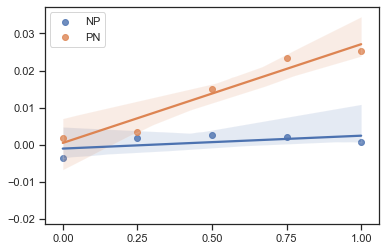

In [20]:
X = list(np.keys())
plt.xticks(FRACS)
sns.regplot(X,[np[c] for c in X],ci=95,scatter=True,label='NP')
sns.regplot(X,[pn[c] for c in X],ci=95,scatter=True,label='PN')
plt.legend();

In [ ]:
fn

In [ ]:
meth = 'spearman'
pg.corr(X,list(fp.values()),method=meth)

In [ ]:
pg.corr(X,list(fn.values()),method=meth)

In [ ]:
linregress(X,list(fn.values()))

In [ ]:
linregress(X,list(fp.values()))

In [ ]:
X,Y = list(dic.keys()),list(dic.values())
plt.ylim(0.2,.4)
sns.regplot(X,Y,order=1);

In [ ]:
X,Y = list(dic.keys()),list(dic.values())
plt.ylim(0.2,.4)
sns.regplot(X,Y,order=1);

In [ ]:
sns.boxplot(data=pd.DataFrame(dic));

In [ ]:
df = pd.read_csv("FP vs FN Noise Impact_10.csv",header=[0,1,2,3],index_col=0)
df.isna().sum().sum(),df.shape

In [ ]:
tmp = df.drop(columns=['pr_rec_score'],level=3,axis=1).droplevel(3,axis=1)  ##pr_rec_score, matthews_corrcoef

In [ ]:
dic = {}
for noise_type in NOISE_TYPES:
    dic[noise_type] = tmp[noise_type].values.reshape(-1)
    print(noise_type,trim_mean(dic[noise_type],.05),dic[noise_type].mean())

In [ ]:
friedmanchisquare(*(dic[a] for a in dic))

In [ ]:
res = pd.DataFrame(dic)
wilcoxon(res['No'],res['FP-Only'])

In [ ]:
f = sns.boxplot(data=res,order=['No','FP-Only','FN-Only','Both']);

In [ ]:
f.get_figure().savefig("figures/FPvsFN4.svg",format='svg')